In [51]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras as ks
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras import layers
import os
import io
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from keras.optimizers import RMSprop
import gc

In [2]:
class MetricsMicro(Callback):
    
    def set_model(self, model):
        self.model = model
        self.val_f1s  = []
        self.val_recalls = []
        self.val_preceisions = []
        
    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(
            self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict, average='micro')
        _val_recall = recall_score(val_targ, val_predict, average='micro')
        _val_precision = precision_score(val_targ, val_predict, average='micro')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_preceisions.append(_val_precision)
        print(' val_f1_micro: %f | val_precision_micro: %f | val_recall_micro: %f'%
             (_val_f1, _val_precision, _val_recall))

In [3]:
##https://drive.google.com/file/d/0B1yuv8YaUVlZZ1RzMFJmc1ZsQmM/view
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying",   
}

In [4]:
replaces = APPO.copy()
replaces['ur'] = 'you are'
replaces['u'] = 'you'
replaces['r'] = 'are'
replaces['yr'] = 'your'

In [5]:
class TokenReplacer():
    def __init__(self, replaces,tokenizer=TweetTokenizer()):
        self.tokenizer= tokenizer
        self.replaces = replaces
    
    def word_replacer(self, word):
        if word in self.replaces:
            return self.replaces[word]
        else:
            return word
    
    def row_rep(self, row):
        tokens = self.tokenizer.tokenize(row)
        return ' '.join([self.word_replacer(token.lower()) for token in tokens])
    
    def turn_rep(self, turn):
        return turn.apply(lambda row : self.row_rep(row))
    
    def replace_data(self, data):
        data_cpy = data.copy()
        for column in data.columns:
            data_cpy[column] = self.turn_rep(data[column])
        return data_cpy

In [8]:
train_data = pd.read_csv('D:\\Machine Learning\\Datasets\\EmoContext\\train.txt',
                        sep='\t', index_col='id')
X_train_org = train_data.iloc[:,:-1]
y_train = train_data.iloc[:,-1]
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [9]:
dev_data = pd.read_csv('D:\\Machine Learning\\Datasets\\EmoContext\\dev.txt',
                        sep='\t', index_col='id')
X_dev_org = dev_data.iloc[:,:-1]
y_dev = dev_data.iloc[:,-1]
y_dev = le.transform(y_dev)

In [10]:
X_test_org = pd.read_csv('D:\\Machine Learning\\Datasets\\EmoContext\\testwithoutlabels.txt',
                        sep='\t', index_col='id')

In [11]:
tr = TokenReplacer(replaces)

In [13]:
X_train = tr.replace_data(X_train_org)
X_dev = tr.replace_data(X_dev_org)
X_test = tr.replace_data(X_test_org)

In [23]:
full_conv_train = X_train[['turn1', 'turn2', 'turn3']].apply(lambda x: ' '.join(x).lower(), axis=1)
full_conv_dev = X_dev[['turn1', 'turn2', 'turn3']].apply(lambda x: ' '.join(x).lower(), axis=1)
full_conv_test = X_test[['turn1', 'turn2', 'turn3']].apply(lambda x: ' '.join(x).lower(), axis=1)

word mean  15.55
word std  6.734142264475674


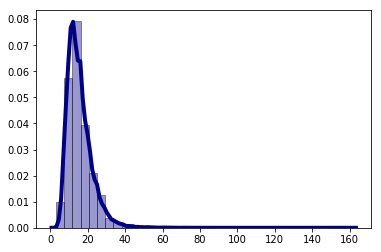

In [24]:
tokenizer = TweetTokenizer()
word_counts = full_conv_train.apply(lambda row: len(tokenizer.tokenize(row)))
print('word mean ', word_counts.mean())
print('word std ', word_counts.std())
sns.distplot(word_counts, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.show()

In [25]:
unique_tokens = set()
full_conv_train.apply(lambda x: unique_tokens.update(tokenizer.tokenize(x)))
len(unique_tokens)

15106

In [27]:
maxlen = 30
max_words = 15000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(full_conv_train)
train_seq = tokenizer.texts_to_sequences(full_conv_train)
dev_seq = tokenizer.texts_to_sequences(full_conv_dev)
test_seq = tokenizer.texts_to_sequences(full_conv_test)

In [28]:
x_train = pad_sequences(train_seq, maxlen=maxlen)
x_dev = pad_sequences(dev_seq, maxlen=maxlen)
x_test = pad_sequences(test_seq, maxlen=maxlen)

In [29]:
glove_dir = r'D:\Machine Learning\Embeddings\glove.twitter.27B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.twitter.27B.200d.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [30]:
embedding_dim = 200

word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [36]:
encoder = LabelBinarizer()
y_train_vec  = encoder.fit_transform(y_train)
y_dev_vec  = encoder.fit_transform(y_dev)

In [37]:
model = Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.GRU(32, dropout=0.3, recurrent_dropout=0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.3))
model.add(layers.Dense(4, activation='softmax'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['acc'])

callbacks = [MetricsMicro()]

history = model.fit(x_train, y_train_vec,
                    epochs=45,
                    batch_size=128,
                    validation_data=(x_dev, y_dev_vec),
                    callbacks=callbacks)

Train on 30160 samples, validate on 2755 samples
Epoch 1/45
30160/30160 [==============================] - 24s 800us/step - loss: 0.9133 - acc: 0.6435 - val_loss: 0.4671 - val_acc: 0.8403
 val_f1_micro: 0.829446 | val_precision_micro: 0.876364 | val_recall_micro: 0.787296
Epoch 2/45
30160/30160 [==============================] - 16s 528us/step - loss: 0.6605 - acc: 0.7533 - val_loss: 0.4372 - val_acc: 0.8432
 val_f1_micro: 0.832613 | val_precision_micro: 0.862928 | val_recall_micro: 0.804356
Epoch 3/45
30160/30160 [==============================] - 17s 548us/step - loss: 0.5962 - acc: 0.7794 - val_loss: 0.4162 - val_acc: 0.8370
 val_f1_micro: 0.831835 | val_precision_micro: 0.859188 | val_recall_micro: 0.806171
Epoch 4/45
30160/30160 [==============================] - 21s 686us/step - loss: 0.5579 - acc: 0.7954 - val_loss: 0.4231 - val_acc: 0.8312
 val_f1_micro: 0.829835 | val_precision_micro: 0.857807 | val_recall_micro: 0.803630
Epoch 5/45
30160/30160 [==============================]

30160/30160 [==============================] - 11s 378us/step - loss: 0.3785 - acc: 0.8629 - val_loss: 0.3918 - val_acc: 0.8461
 val_f1_micro: 0.846436 | val_precision_micro: 0.856824 | val_recall_micro: 0.836298
Epoch 38/45
30160/30160 [==============================] - 11s 380us/step - loss: 0.3743 - acc: 0.8648 - val_loss: 0.3536 - val_acc: 0.8639
 val_f1_micro: 0.865004 | val_precision_micro: 0.874305 | val_recall_micro: 0.855898
Epoch 39/45
30160/30160 [==============================] - 11s 376us/step - loss: 0.3709 - acc: 0.8656 - val_loss: 0.3554 - val_acc: 0.8679
 val_f1_micro: 0.867572 | val_precision_micro: 0.876900 | val_recall_micro: 0.858439
Epoch 40/45
30160/30160 [==============================] - 11s 380us/step - loss: 0.3730 - acc: 0.8652 - val_loss: 0.3821 - val_acc: 0.8512
 val_f1_micro: 0.852730 | val_precision_micro: 0.864009 | val_recall_micro: 0.841742
Epoch 41/45
30160/30160 [==============================] - 11s 381us/step - loss: 0.3754 - acc: 0.8655 - val_los

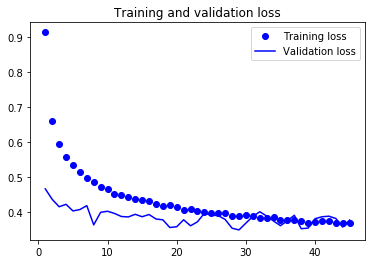

In [38]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [39]:
test_pred = model.predict(x_test)

In [47]:
test_pred = test_pred.argmax(axis=1)

In [49]:
test_labels = le.inverse_transform(test_pred)

In [52]:
solutionPath = 'D:\\Machine Learning\\Datasets\\EmoContext\\test.txt'
testDataPath = 'D:\\Machine Learning\\Datasets\\EmoContext\\testwithoutlabels.txt'
with io.open(solutionPath, "w", encoding="utf8") as fout:
        fout.write('\t'.join(["id", "turn1", "turn2", "turn3", "label"]) + '\n')        
        with io.open(testDataPath, encoding="utf8") as fin:
            fin.readline()
            for lineNum, line in enumerate(fin):
                fout.write('\t'.join(line.strip().split('\t')[:4]) + '\t')
                fout.write(test_labels[lineNum] + '\n')